# Aktivierungen für verschiedene Ereignisse

### module importieren

In [30]:
import numpy as np
from nilearn import image, input_data, plotting
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame

sns.set_context('poster')

### Dateiname des funktionellen Bildes

In [2]:
epi_file = '../data/sub-01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'

In [3]:
epi_file

'../data/sub-01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'

### Maske definieren

Die Daten werden präprozessiert; dies umfasst:
* z-Transformation des Zeitverlaufs jedes Voxels
* räumliche Glättung

In [32]:
brain_masker = input_data.NiftiMasker(mask_img='../external/MNI152_T1_2mm_brain_mask.nii.gz',
                                standardize=True,
                                smoothing_fwhm=8).fit()

In [5]:
mean_img = image.mean_img(epi_file)

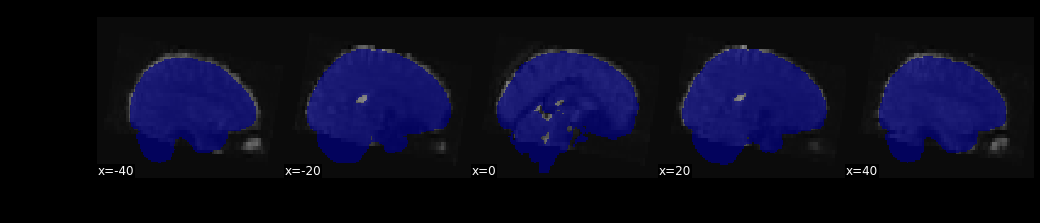

In [33]:
plotting.plot_roi(brain_masker.mask_img_,
                  bg_img=mean_img,
                  display_mode='x',
                  cut_coords=range(-40,41,20))
plt.show()

### Voxelwerte auslesen und in Tabelle umwandeln

In [ ]:
epi_data = brain_masker.transform(epi_file)

In [8]:
epi_df = pd.DataFrame(epi_data)

In [9]:
epi_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,228473,228474,228475,228476,228477,228478,228479,228480,228481,228482
198,1.382881,0.988377,0.622357,1.588949,1.145390,2.058703,1.637509,1.206544,1.524183,0.373292,...,-0.745036,-1.068331,1.223884,0.690487,0.104411,-0.377628,0.877094,0.201367,-0.307948,-0.129213
199,0.319281,0.015208,-0.368842,0.445116,0.074239,0.967761,0.602128,0.184722,0.729344,-1.367070,...,0.102807,-0.616292,-0.194974,-0.601147,-0.790260,-0.727877,-0.569801,-0.872991,-0.884107,-0.952479
200,1.180239,1.023838,0.789041,1.248082,1.098227,1.436483,1.344111,1.219919,1.407007,0.101427,...,0.348382,-0.149989,0.213004,0.046755,-0.113123,-0.321587,0.058131,-0.241445,-0.396383,-0.309464
201,0.844750,0.648460,0.459837,1.120717,0.925154,1.579997,1.383112,1.201520,1.539666,-0.440359,...,0.324250,0.420882,0.147412,0.042060,-0.071371,-0.170758,0.144248,-0.151464,-0.350428,-0.257396
202,1.198560,0.895435,0.522743,1.419399,1.198853,1.628112,1.585622,1.465535,1.696706,-0.443028,...,0.826416,0.552048,1.519291,1.150949,0.583072,0.066379,0.997120,0.574089,0.183750,0.266621


### Studiendesign über den Zeitverlauf einer Region definieren

Koordinaten der interessierenden Region

In [10]:
my_seeds = [ (0,-50,30) ]

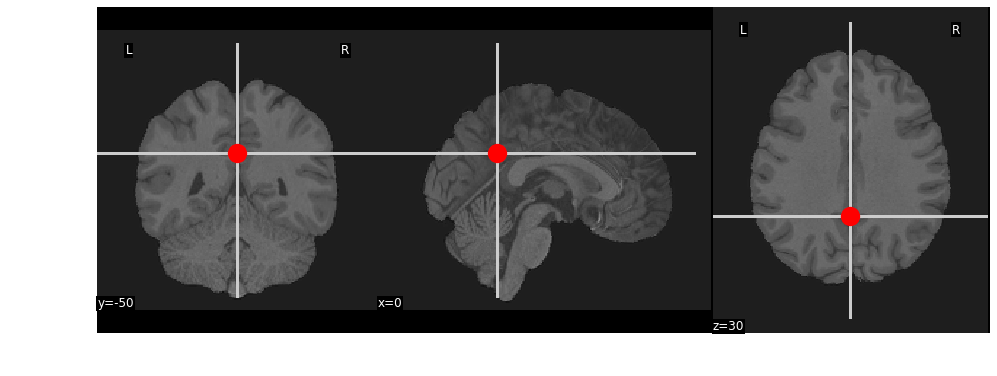

In [11]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
display = plotting.plot_anat('../data/sub-01_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz',
                             cut_coords=my_seeds[-1],
                             axes=ax)
display.add_markers(my_seeds,marker_size=300)
plt.show()

### Falsches Vorgehen: Drifts sind in den Daten

In [12]:
seed_masker = input_data.NiftiSpheresMasker(seeds=my_seeds,
                                            radius=5,
                                            standardize=True,
                                            smoothing_fwhm=8).fit()

Daten extrahieren

In [ ]:
seed_data = seed_masker.transform(epi_file)

seed_df = pd.DataFrame(seed_data)
seed_df.columns = ['signal']

Signalverlauf im Seed-Voxel visualisieren

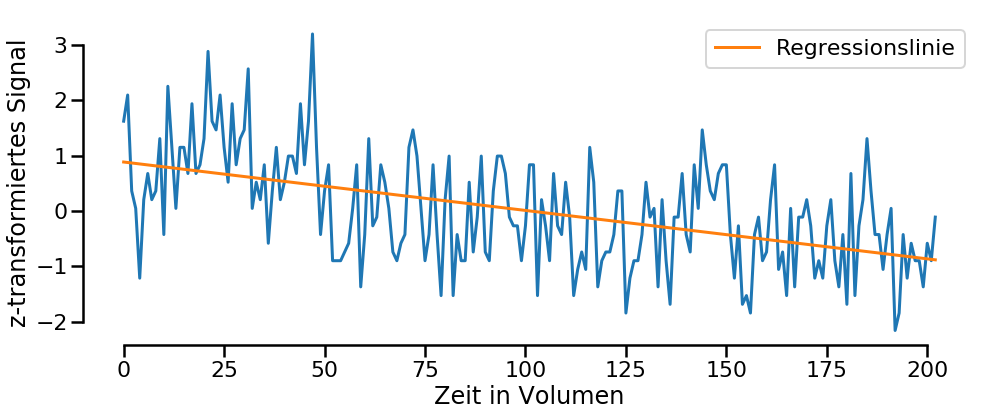

In [14]:
plt.figure(figsize=(16,6))

# die Daten der Seed-Region
plt.plot(seed_df)

# die Ergebnisse der linearen Regression
linreg_results = stats.linregress(seed_df.index,seed_df['signal'])
plt.plot([linreg_results.intercept+linreg_results.slope*x for x in seed_df.index],
         label='Regressionslinie')

plt.ylabel('z-transformiertes Signal')
plt.xlabel('Zeit in Volumen')
plt.legend()
sns.despine(trim=True)
plt.show()

Korrelation des Zeitverlaufs jedes Voxels mit dem Seed-Voxel

In [15]:
corr_df = epi_df.corrwith(seed_df.loc[:,'signal'])

Korrelationen im Hirnraum visualisieren

In [ ]:
corr_im = brain_masker.inverse_transform(corr_df)

In [ ]:
plotting.view_img(corr_im,threshold=0.4)

Problem: Korrelationen spiegeln niedrigfrequente (Scanner-)Drifts wieder, nicht das höherfrequente auf und ab der hämodynamischen Antwort.

### Richtiges Vorgehen: Drifts wurden entfernt

Die Korrelationen spiegeln dann nur noch die höherfrequente Hämodynamische Antwort wieder und nicht mehr die Drifts die die Korrelationen überlagern können.

Extraktion der Daten aus der Region (wichtig: Präprozessierung wie für whole-brain Analyse)

In [18]:
my_standard = True
my_detrend = True
my_smoo = 8

In [ ]:
brain_masker = input_data.NiftiMasker(mask_img='../external/MNI152_T1_2mm_brain_mask.nii.gz',
                                standardize=my_standard,
                                detrend=my_detrend,
                                smoothing_fwhm=my_smoo).fit()

epi_data = brain_masker.transform(epi_file)
epi_df = pd.DataFrame(epi_data)

In [20]:
seed_masker = input_data.NiftiSpheresMasker(seeds=my_seeds,
                                            radius=5,
                                            standardize=my_standard,
                                            detrend=my_detrend,
                                            smoothing_fwhm=my_smoo).fit()

In [ ]:
seed_data = seed_masker.transform(epi_file)

seed_df = pd.DataFrame(seed_data)
seed_df.columns = ['signal']

In [22]:
seed_df.tail()

,signal
198,-0.059425
199,-0.599815
200,0.328008
201,-0.028856
202,0.898967


Check: wenn das Detrending funktioniert hat, dann muss der Signalverlauf über alle Volumen hinweg flach sein

In [23]:
linreg_results = stats.linregress(seed_df.index,seed_df['signal'])

In [24]:
print('Schnittpunkt der y-Achse=%.5f\nSteigung der Geraden=%.5f'%(linreg_results.intercept, linreg_results.slope))

Schnittpunkt der y-Achse=-0.00000
Steigung der Geraden=0.00000


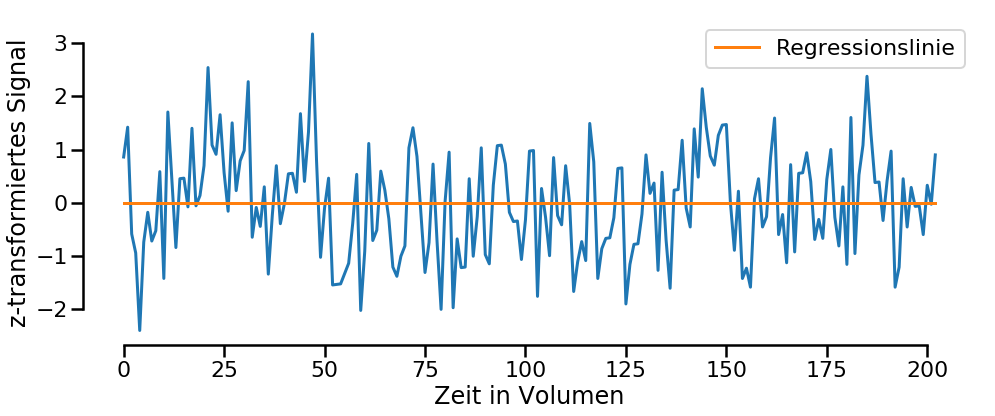

In [25]:
plt.figure(figsize=(16,6))

# die Daten der Seed-Region
plt.plot(seed_df)

# die Ergebnisse der linearen Regression
plt.plot([linreg_results.intercept+linreg_results.slope*x for x in seed_df.index],
         label='Regressionslinie')

plt.ylabel('z-transformiertes Signal')
plt.xlabel('Zeit in Volumen')
plt.legend()
sns.despine(trim=True)
plt.show()

### Korrelation jedes Voxels mit dem Seed-Voxel

In [26]:
corr_df = epi_df.corrwith(seed_df.loc[:,'signal'])

In [27]:
corr_df.tail()

228478    0.351649
228479    0.310144
228480    0.360329
228481    0.378330
228482    0.376143
dtype: float64

### Visualisierung der Eregbnisse im Hirnraum

In [ ]:
corr_im = brain_masker.inverse_transform(corr_df)